# Ex3. Siamese networks and one-shot learning

Tore Aadland

Git repository:  https://github.com/ToreAad/plankton-siamese

## Introduction
The objective of the exercise was to train a vector embedding, visualize it and design a suitable classification scheme that uses the vector embedding. The dataset used to find the embedding was the 2 Gb subset of the ZooScanNet data set provided in the assinment. This dataset was split into training and validation sets that was used to evaluate the performance of a plankton classifier. In addition I extracted 5 images from each of the classes in the original 9gb ZooScanNet data set not included in the 2Gb subset. These images were used to evaluate the performance of a one-shot classifier based on the vector embeddings I found.

Here is a short summary of my approach to deliver on this objective:
- I use transfer learning to train a classifier based on inception. It has an accuracy of about 87% on the validation set.
- I use this inception based classifier in a siamese network that I train on two different loss functions arriving at two different vector embeddings. The first loss function is the simple one presented in class, the second is a custom loss function I made to include prior knowledge on the taxonomy of the plankton in the embedding space.
- For classification I found that 5-nearest neighbours on the vector embedding found using the standard loss function presented in class performed well.
- One-shot learning produced interesting results. The best vector embedding indicates that one-shot learning is capable of identifying true positives and true negatives about 95% of the time. The general accuracy of the one-shot learning classifier was about .

### Organization of project
- This notebook is the main part of report. It presents visualization of the clustering of classes in the embedding space, and the performance of the classifiers based on this vector embedding.
- The git repository: https://github.com/ToreAad/plankton-siamese contains the code developed during this exercise.
    - config.py contains global parameters
    - create_base_model.py contains code to initialize and train the inception model based NN used in the siamese NN.
    - create_siamese_model.py contains the code to initialize and train the siamese NN.
    - generators.py contains the code used to implement the data generators used during this assignment.
    - hierarchy.txt contains the taxonomic tree used to train the second embedding explored.
    - read_hierarchy.py contains code to parse hierarchy.txt, and to retrieve taxonomic distances from the tree.

### Custom loss function
In this assignment I consider two vector embeddings. One standard using the std_triplet_loss function, that is:
$$\mathcal{L} = \max(d_{pos}^2+ \alpha - d_{neg}^2, 0)$$,
where $d_{pos}$ and $d_{neg}$ is the distance between the positive and negative example and the anchor respectively, and $\alpha$ is some hyperparameter set to 5. The second embedding is found buy including the taxonomic distance in the loss function. In particular, it was found training a siamese neural network using the following loss function:
$$\mathcal{L} = d_{pos}+ \alpha|d_{true} - d_{neg}|$$,
where $d_{true}$ is the true distance between the anchor and the negative example as indicated by the taxonomic tree of the ZooScanNet dataset. As a distance metric I use the taxonomic distance as defined in: http://www.coastalwiki.org/wiki/Measurements_of_biodiversity, that is, the path between two leafes of a phylogenetic tree. This metric conforms to the triangle inequality. As the metric is only sensible when applied to taxonomic labels I do not include the egg__other and multiple__other classes when training and exploring this vector embedding.

### Notes on speeding up training time with redis.
I have identified reading image files of disk as a significant bottleneck in model training. As is, reading 2000 images takes about 45-50 seconds. I have addressed this by loading the images in a in-memory database called redis. It offers persistence by storing the entire database as a single file on the hard-drive, which apparently is much faster to load into memory than the image files seperately. This has significantly sped up training times.

### Notes on successful transfer learning
In this exercise I use the inception network as a base for my siamese network. In an exercise 1 I had problems getting good performance from this approach. This time I managed to make the model perform better on the dataset. I attribute this to two steps taken:
- I add a batch normalization layer before inception input layer.
- I use the tensorflow.keras implementation instead of the "default" keras implementation.
I strongly suspect that my problems with transfer learning in the earlier exercise is related to the problems discussed in the followng blog-post: https://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/ or some variation related to the problems discussed therein.

## Finding embeddings

I explored two different vector embeddings. Embedding 1 uses the loss function presented in class, embedding 2 uses the custom loss function presented above. Both embeddings are found by training siamese neural networks with the same architecture. The siamese neural network is based on an adaption of the inception model which has been customised using transfer learning.

So, the first thing I did was to train the inception model on the training dataset. After 25 epochs each training 20*1000 images I get an accuracy of about 87%.

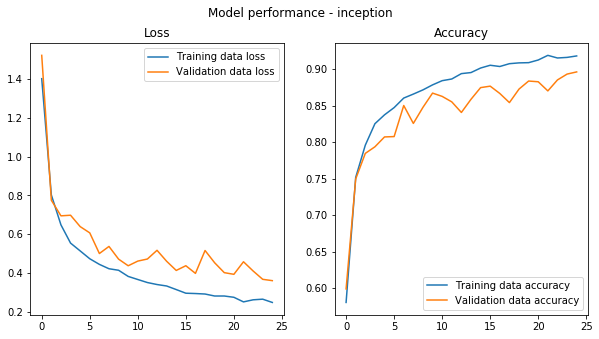

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("history_trained_"+C.base_model)

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training data loss')
    plt.plot(history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history['acc'], label='Training data accuracy')
    plt.plot(history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Model performance - {}".format(C.base_model))
    plt.show()
plot_history(df)

I then use the trained inception model as a base in a siamese network. I train two variations of this network each using one of the loss functions presented earlier. I train them for about 25 epochs which appears to be sufficent for an overal idea of embedding performance. First let me present the functions used to visualize the embeddings:

In [1]:
from create_siamese_model import initialize_bitvector_model, model_path
import pandas as pd
from tensorflow.keras.models import load_model
from generators import Singlet
import config as C
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
from read_hierarchy import taxonomic_grouping, taxonomic_path, taxonomic_ordering
import plotly.offline as pyo

import plotly.graph_objs as go

pyo.init_notebook_mode()

def make_taxonomic_distance_plot(X_2d, y):
    j = 13
    groups = taxonomic_grouping(j)
    sets = set([j for j, _ in groups.values()])
    cmap = plt.cm.get_cmap('afmhot')
    
    data = []
    for i in range(40):
        j, name = groups[i]
        color = "rgba({}, {}, {}, {})".format(*[int(col*255) for col in cmap(taxonomic_ordering(name))])
        obj = go.Scattergl(
            x=X_2d[y==i, 0],
            y= X_2d[y==i, 1],
            mode = 'markers',
            marker = dict(
                size=10,
                color = color
            ),
            name = name,
            text = "->".join(taxonomic_path(i)),
            showlegend=False,
            hoverinfo = 'text'
        )
        data.append(obj)
        
    layout = go.Layout(
        autosize=False,
        width=1024,
        height=768,
        hovermode="closest",
        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )
    fig = go.Figure(data=data, layout=layout)
    
    pyo.iplot(fig)

    
def make_uniqueness_plot(X_2d, y):
    j = 13
    groups = taxonomic_grouping(j)
    sets = set([j for j, _ in groups.values()])
    cmap = plt.cm.get_cmap('hsv', 40)
    
    data = []
    for i in range(40):
        j, name = groups[i]
        color = "rgba({}, {}, {}, {})".format(*[int(col*255) for col in cmap(i)])
        obj = go.Scattergl(
            x=X_2d[y==i, 0],
            y= X_2d[y==i, 1],
            mode = 'markers',
            marker = dict(
                size=10,
                color = color
            ),
            name = name,
            text = "->".join(taxonomic_path(i)),
            showlegend=False,
            hoverinfo = 'text'
        )
        data.append(obj)
        
    layout = go.Layout(
        autosize=False,
        width=1024,
        height=768,
        hovermode="closest",
        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )
    fig = go.Figure(data=data, layout=layout)
    
    pyo.iplot(fig)
    
def get_embedding(model, datagen, exclude):
    imgs = []
    labels = []
    embeddings = []
    while len(labels) <= len(datagen):
        X, y = datagen[0]
        if y in exclude:
            continue
        imgs.append(X)
        labels.append(y)
        embeddings.append(model.predict_on_batch(X))

    X = np.stack(embeddings).reshape((len(labels), model.output_shape[1]))
    y = np.asarray(labels).reshape((len(labels),))
     
    return X, y
    
    
def get_val_embedding(model, nrSamples = 1000, exclude=[]):
    nrSamples = 1000
    datagen = Singlet(batch_size=1, directory=C.val_dir, steps_per_epoch=nrSamples)
    return get_embedding(model, datagen, exclude)
    
def get_train_embedding(model,nrSamples = 1000, exclude=[]):
    nrSamples = 1000
    datagen = Singlet(batch_size=1, directory=C.val_dir, steps_per_epoch=nrSamples)
    return get_embedding(model, datagen, exclude)

tsne = TSNE(n_components=2, random_state=0, n_iter=3000)
mds = MDS(n_components=2)

Then lets get some vector embedding data points by sampling the training data set:

In [2]:
bitvector_model = load_model(model_path("bitvector_"+C.base_model))
bitvector_X, bitvector_y = get_train_embedding(bitvector_model, 5000)

bitvector_X_2d_tsne = tsne.fit_transform(bitvector_X)
bitvector_X_2d_mds = mds.fit_transform(bitvector_X.astype(np.float64))

Instructions for updating:
Colocations handled automatically by placer.


Now, lets use 2 component tsne for dimensionality reduction, and see how well the classes has been clustered in the embedding space. See from the following figure that when I use the std_triplet_loss function I get an embedding that produces clusters that are more or less unique for each of the classes.

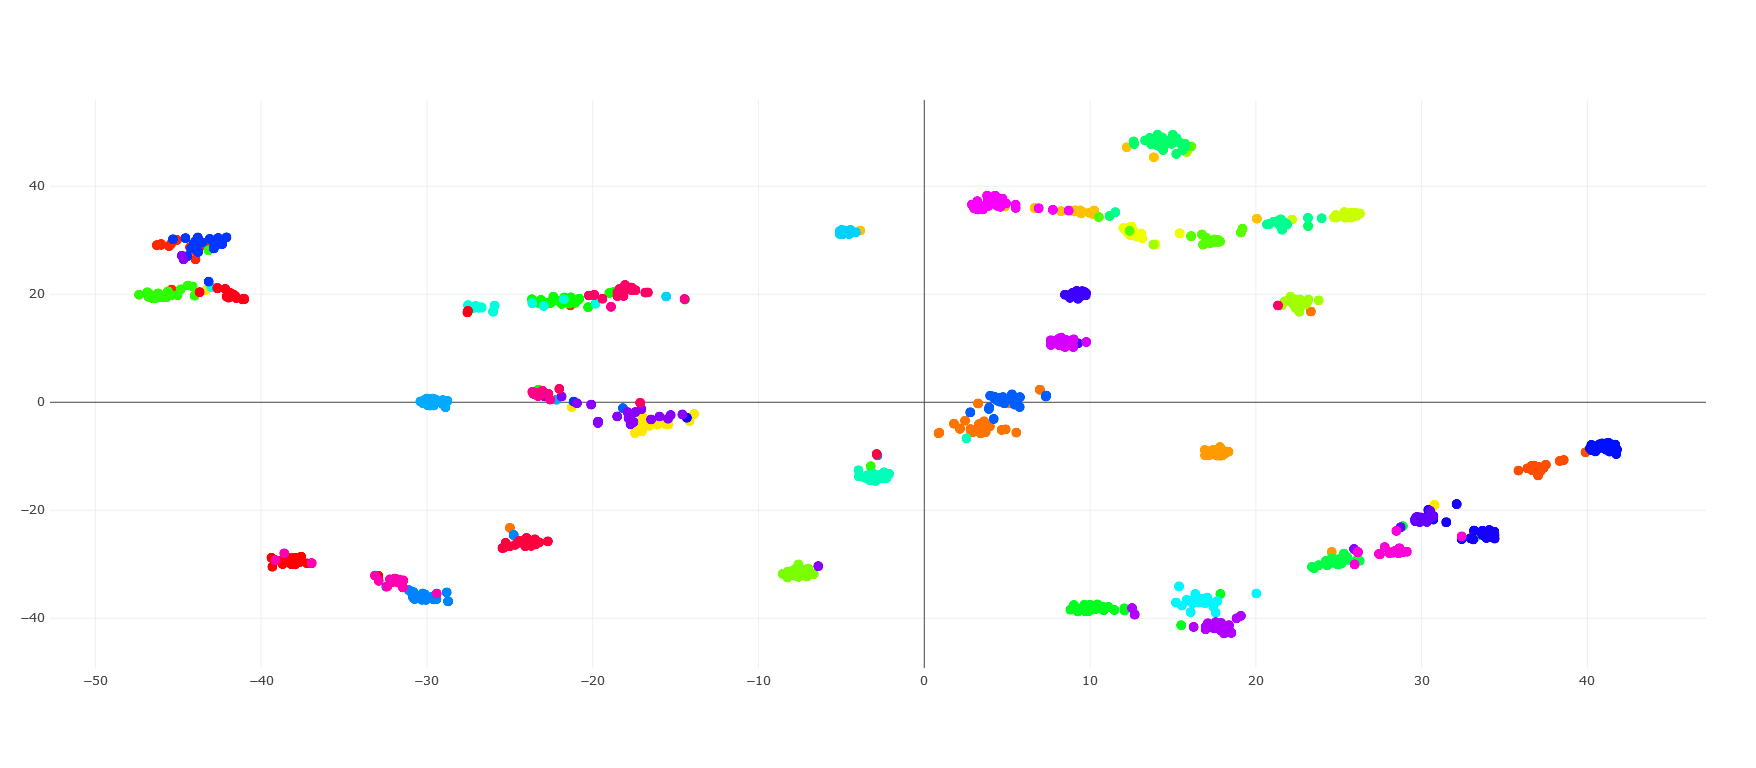

In [3]:
make_uniqueness_plot(bitvector_X_2d_tsne, bitvector_y)

Now, lets use an MDS embedding for dimensionality reduction. Sklearn documentation indicates that this algorithm preserves the distance between pairs of points, although I am a little uncertain on how to interpret this intuition. I am curious if the the standard loss function will map taxonomically close classes next to each other in the embedding space. To test this I order the features by taxonomic distance to the root, and see if there is a nice pattern to be seen in the a scatter plot using the MDS embedding. From the following plot we do not see any indication that the taxonomic distance between the classes is preserved in the embedding found using the standard loss function:

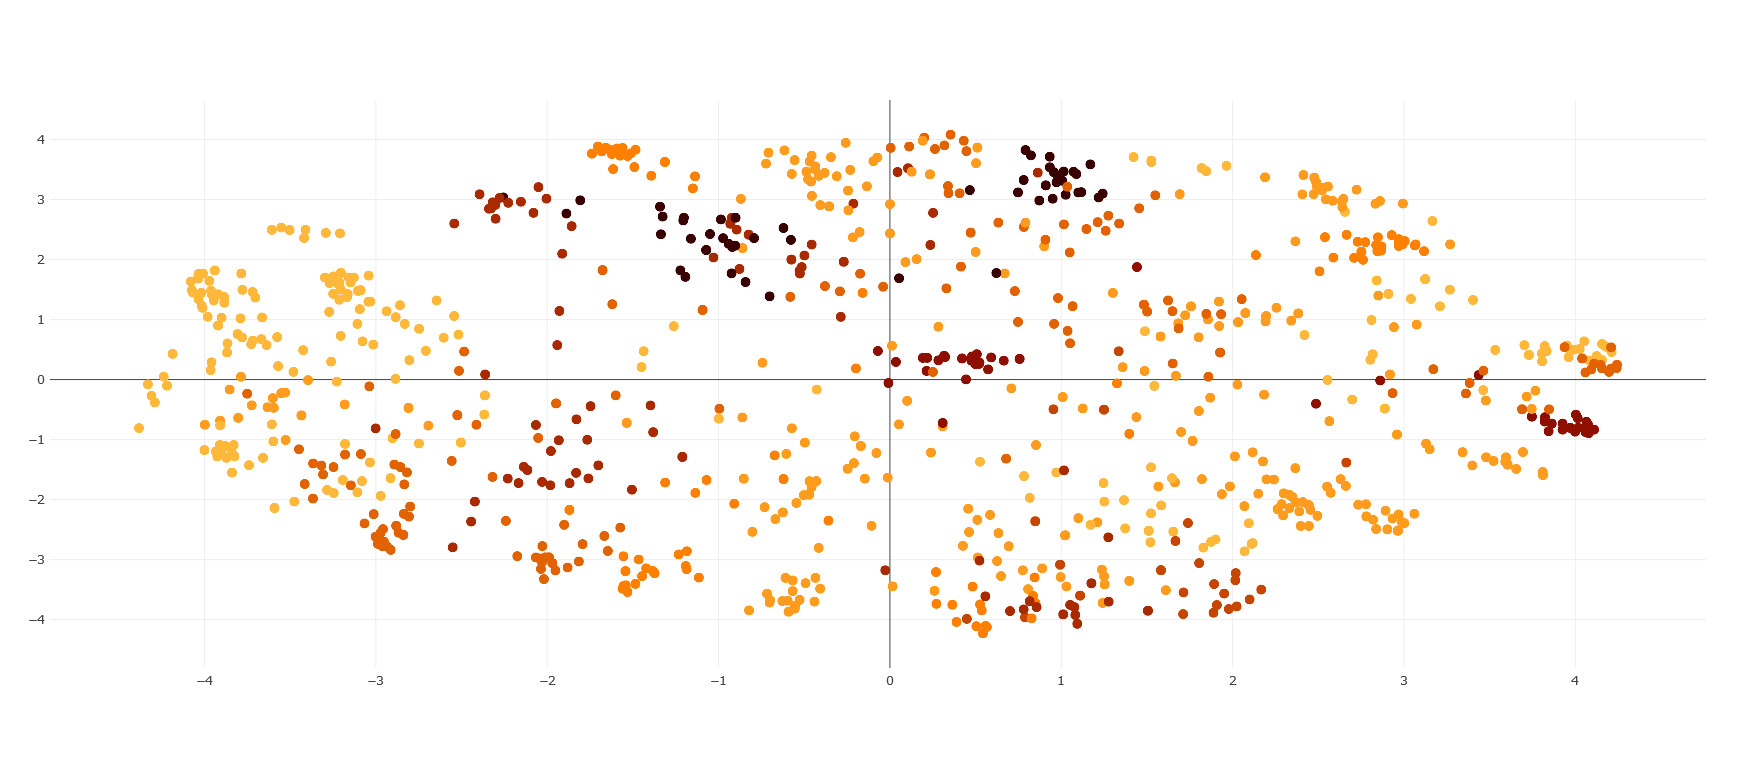

In [4]:
make_taxonomic_distance_plot(bitvector_X_2d_mds, bitvector_y)

In fact it is clear from the following plot that most features in the embedding space are equidistant, with a mean distance that equals the $\alpha$ parameter set during training. 

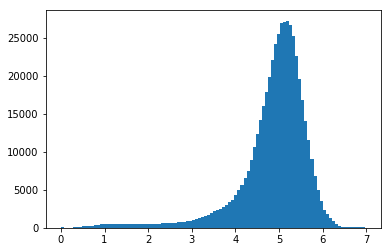

In [5]:
distances = []

for i in range(len(bitvector_X)-1):
    for j in range(i+1, len(bitvector_X)):
        distances.append(np.linalg.norm(bitvector_X[i]-bitvector_X[j]))
plt.hist(distances, bins=100)
plt.show()

From this I tentatively conclude that the distance in the embedding space found using the standard loss function is informative only about whether two instances belong too the same class, and not so much on how different they are taxonomically/ morphologically. Note further that almost no distances are less than 0.1, this indicates that the clustering of each class is rather weak.

Now lets consider embedding found when using the loss function that takes advantag of the taxonomic distance between the classes. First lets load the data:

In [6]:
hierarchy_bitvector_model = load_model(model_path("hierachy_bitvector_"+C.base_model))
hierachy_bitvector_X, hierachy_bitvector_y = get_train_embedding(hierarchy_bitvector_model, 5000, exclude=[C.plankton_str2int["egg__other"], C.plankton_str2int["multiple__other"]])

hierachy_bitvector_X_2d_tsne = tsne.fit_transform(hierachy_bitvector_X)
hierachy_bitvector_X_2d_mds = mds.fit_transform(hierachy_bitvector_X.astype(np.float64))

We see from the following plot that it to produces nice clusters, unfortunately it appears that the class uniqueness of these clusters is worse than those found by using the standard loss function presented in class:

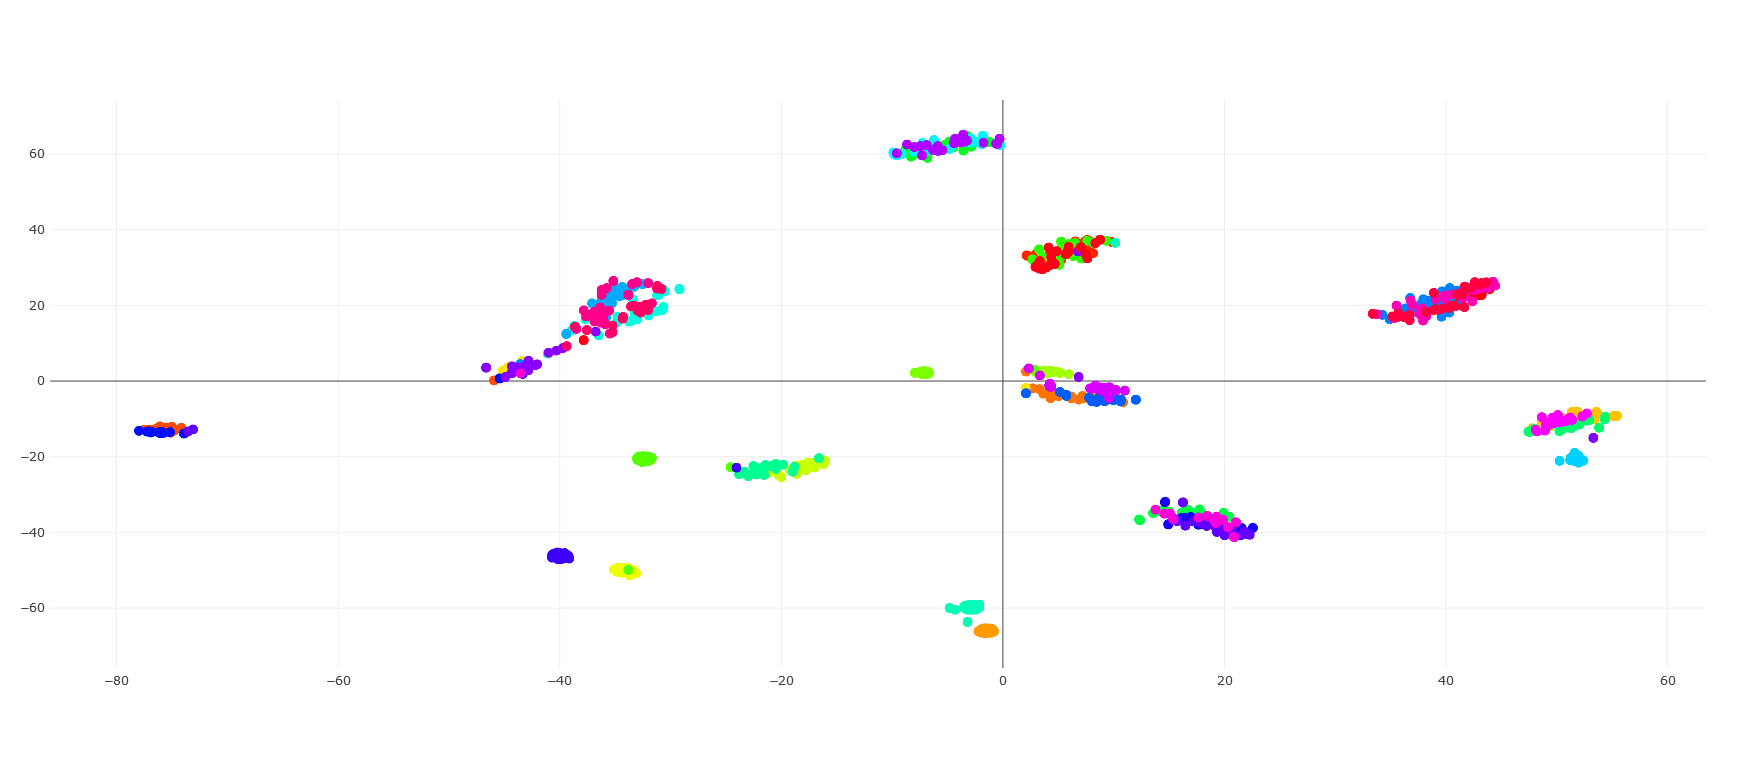

In [7]:
make_uniqueness_plot(hierachy_bitvector_X_2d_tsne, hierachy_bitvector_y)

Now, the second loss function was designed to imbue the embedding space with some taxonomic a priori knowledge. However the following 2 component MDS dimensionality reduction plot does does not reflect any such structure.

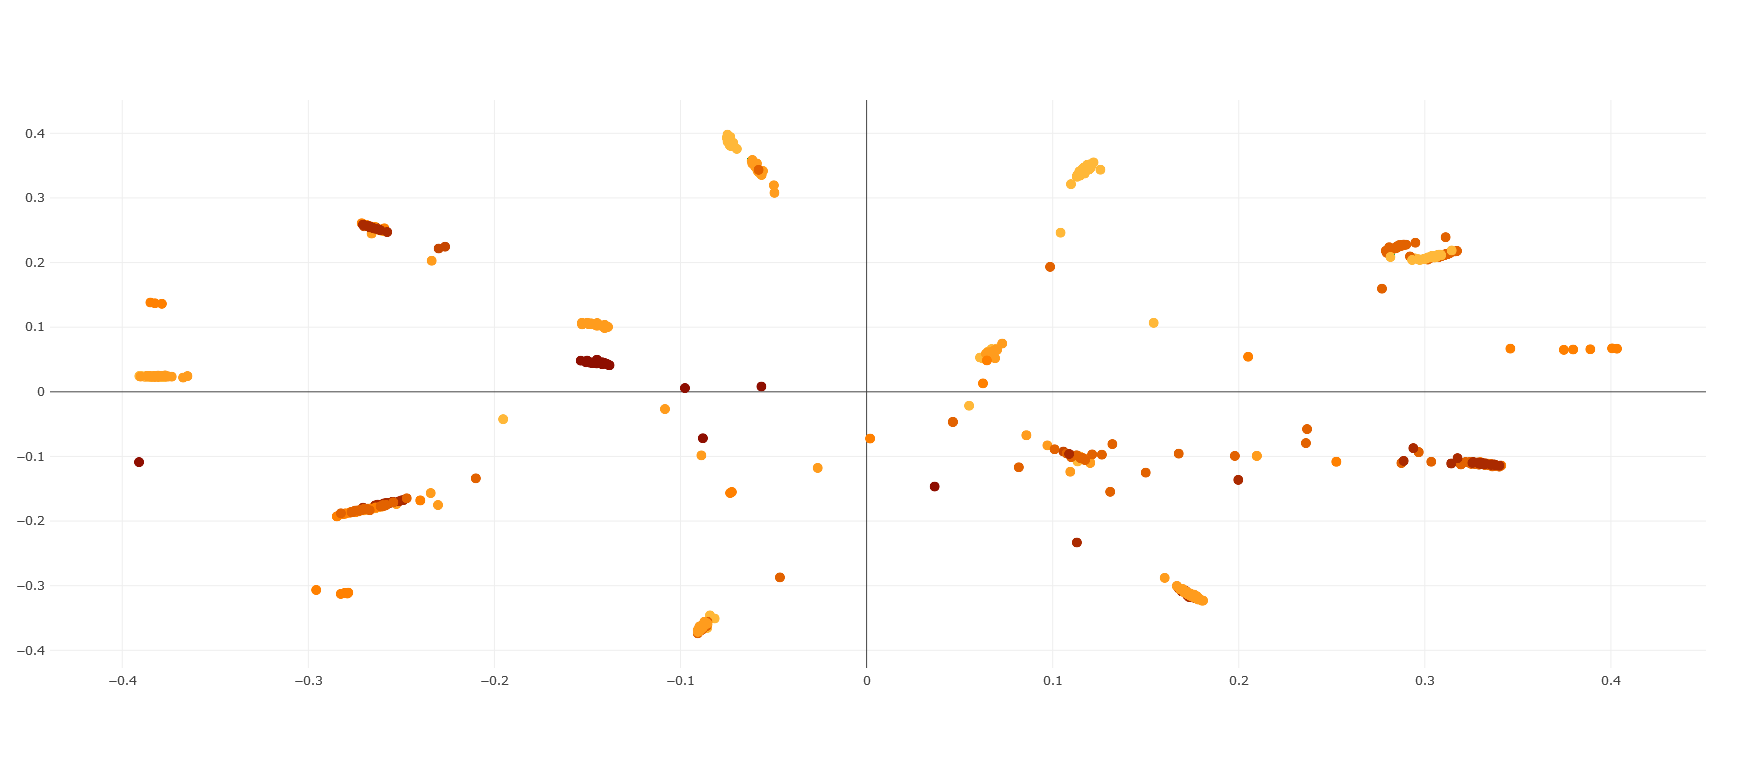

In [8]:
make_taxonomic_distance_plot(hierachy_bitvector_X_2d_mds, hierachy_bitvector_y)

The following plot demonstrates that there dosen't appear to be much more variation in the distances between points in this embedding either, although there are more distances close to zero. This indicates that the siamese model was not able to find an embedding that preserved the taxonomic distances indicated by the hierarchy.txt taxonomic tree, but it did facilitate greater clustering of some of the datapoints.

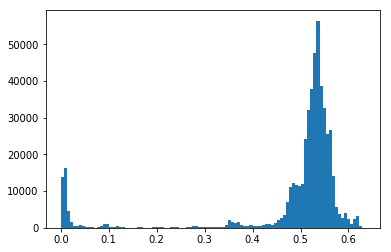

In [9]:
distances = []

for i in range(len(hierachy_bitvector_X)-1):
    for j in range(i+1, len(hierachy_bitvector_X)):
        distances.append(np.linalg.norm(hierachy_bitvector_X[i]-hierachy_bitvector_X[j]))
plt.hist(distances, bins=100)
plt.show()

## Classifier
Lets first consider the first embedding. First lets train a classifier using the training data:

In [10]:
from sklearn.neighbors import KNeighborsClassifier
embedding_1_classifier = KNeighborsClassifier(n_neighbors=5).fit(bitvector_X, bitvector_y)

Now lets generate som validation data to evaluate the classifier performance:

In [11]:
val_bitvector_X, val_bitvector_y = get_val_embedding(bitvector_model, 2000)
embedding_1_classifier.score(val_bitvector_X, val_bitvector_y)

0.8551448551448552

A score of 86% on the validation data is about the same as the performance I achieved on the pretrained inception model that I used as a base for the siamese NN. So this is OK performance. Lets visualize the model performance using a confusion matrix:

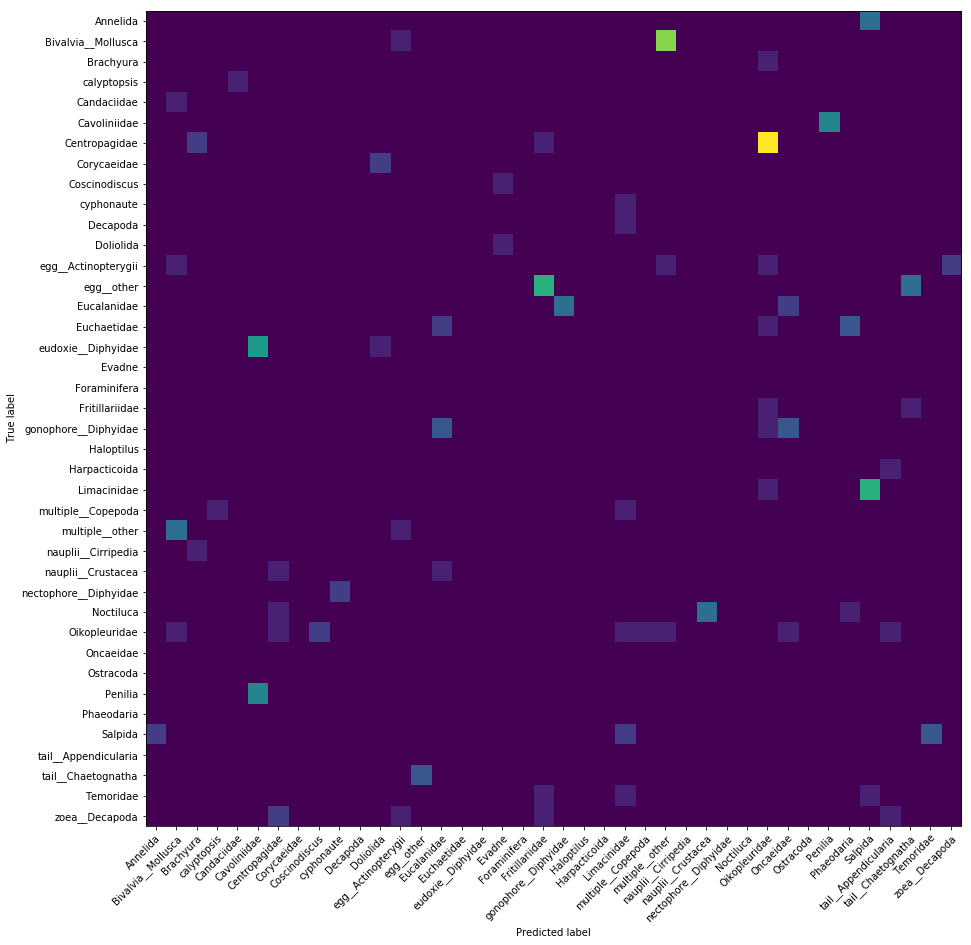

In [12]:
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(embedding_1_classifier.predict(val_bitvector_X), val_bitvector_y)

classes = [C.plankton_int2str[i] for i in range(40)]

for i in range(40):
    cm [i,i] = 0

fig, ax = plt.subplots(figsize=(15,15))    
ax.imshow(cm)#
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.show()

Looks OK.

Now, lets repeat for the second embedding. Lets train a classifier using training data:

In [13]:
from sklearn.neighbors import KNeighborsClassifier
embedding_3_classifier = KNeighborsClassifier(n_neighbors=5).fit(tst_hierarchy_bitvector_X, tst_hierarchy_bitvector_y)

Now lets generate som test data to evaluate the classifier performance:

In [14]:
val_hierachy_bitvector_X, val_hierachy_bitvector_y = get_val_embedding(hierarchy_bitvector_model, 2000, exclude=[C.plankton_str2int["egg__other"], C.plankton_str2int["multiple__other"]])
embedding_2_classifier.score(val_hierachy_bitvector_X, val_hierachy_bitvector_y)

0.7102897102897103

71% percent accuracy is quite alot less than what I go using the pretrained inception model, and what I got by using a nearest neightbour classifier in combination with the other embedding transformation. I also found that the performance of the nearest neighbour classifier got significantly worse as I increased k, indicating that this NN provides a less unique mapping of the classses to the embedding space.

The confusion matrix for this classifier looks OK too:

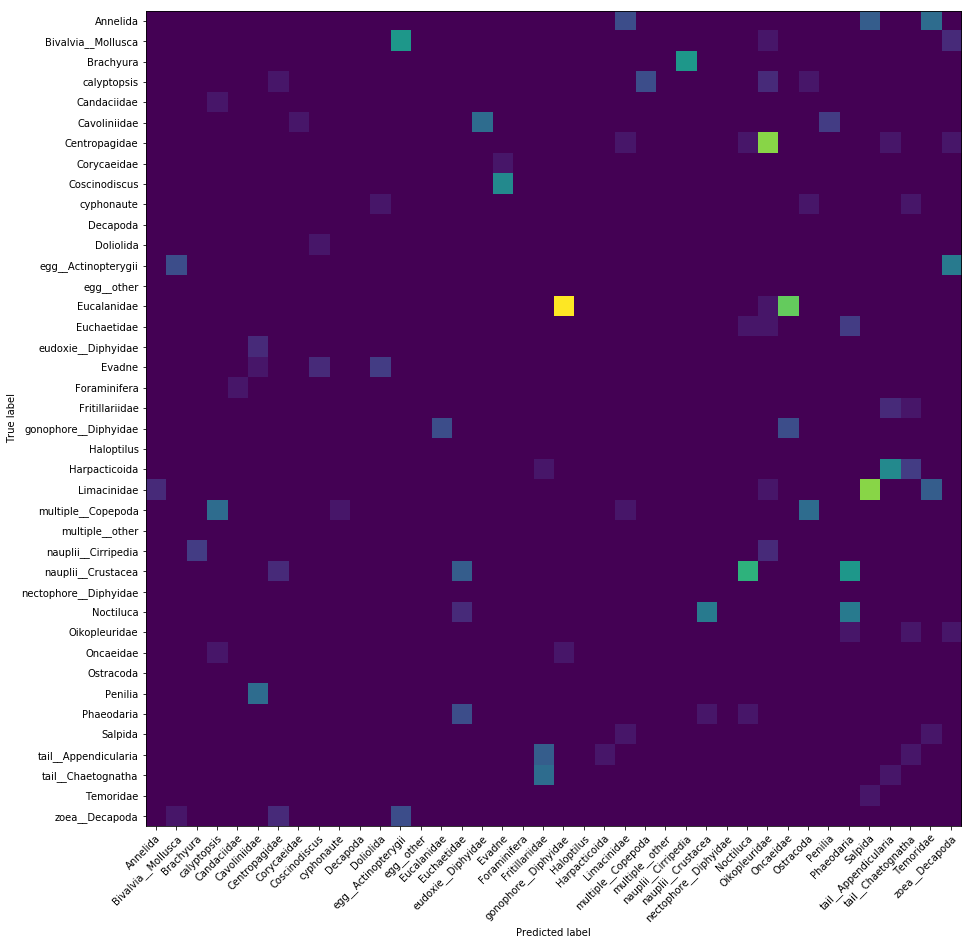

In [15]:
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(embedding_2_classifier.predict(val_hierachy_bitvector_X), val_hierachy_bitvector_y, range(40))

classes = [C.plankton_int2str[i] for i in range(40)]

for i in range(40):
    cm [i,i] = 0

fig, ax = plt.subplots(figsize=(15,15))    
ax.imshow(cm)#
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.show()

# One-shot learning

To evaluate the performance of the vector embeddings I found I considered the rest of the classes in the ZooScanNet that was not included in the 2 Gb dataset provided in the assignment.

First let me present an utility method that calculates the true positives, true negatives, as well as conditional probabilities that indicates how much we can trust the distance in the vector embedding as a classifier. 

In [8]:
def avg(x):
    return sum(x)/len(x)

def evaluate_one_shot_learning(X, y, thresh, title=""):
    frequency_same_class = []
    same_class = []
    different_class = []
    small_distance = []
    for i in range(len(X) - 1):
        for j in range(i+1, len(X)):
            distance = np.linalg.norm(X[i] - X[j])
            if distance < thresh:
                small_distance.append(1)
            else:
                small_distance.append(0)
            
            if y[i] == y[j]:
                same_class.append(distance)
                frequency_same_class.append(1)
            else:
                different_class.append(distance)
                frequency_same_class.append(0)
    
    prob_small_distance = avg(small_distance)
    prob_same_class = avg(frequency_same_class)
    prob_small_distance_given_same_class = avg([c < thresh for c in same_class])
    prob_large_distance_given_different_class = avg([c > thresh for c in different_class])
    
    plt.title(title+"Probability small distance given same class: {:2f}%".format(prob_small_distance_given_same_class))
    plt.hist(same_class)
    plt.vlines(thresh, plt.gca().get_ylim()[0],plt.gca().get_ylim()[1])
    plt.show()

    plt.title(title+"Probability large distance given different class: {:2f}%".format(prob_large_distance_given_different_class))
    plt.hist(different_class)
    plt.vlines(thresh, plt.gca().get_ylim()[0],plt.gca().get_ylim()[1])
    plt.show()
    
    print("Probability same class given small distance: {}".format(prob_small_distance_given_same_class*prob_same_class/prob_small_distance))
    print("Probability different class given large distance: {}".format(prob_large_distance_given_different_class*(1-prob_same_class)/(1-prob_small_distance)))

datagen = Singlet(batch_size=1, directory="/home/jupyter/zooscannet/data", steps_per_epoch=1000)

Lets evaluate the performance of the first embedding based on the standard loss function. First I consider the classes contained in the 2Gb dataset we used to train the Siamese NN.

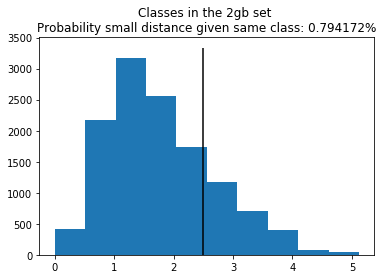

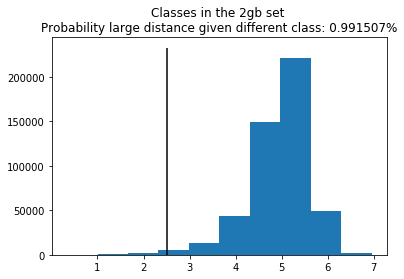

Probability same class given small distance: 0.7047300185211568
Probability different class given large distance: 0.9947292902631655


In [9]:
bitvector_model = load_model(model_path("bitvector_"+C.base_model))
bitvector_X, bitvector_y = get_val_embedding(bitvector_model, 2000)
evaluate_one_shot_learning(bitvector_X, bitvector_y, 2.5, "Classes in the 2gb set \n")

The one-shot learning algorithm appears to be performing ok on the validation data! Lets evaluate it performance on the ZooScanNet classes not included in the 2Gb dataset provided in the assignment:

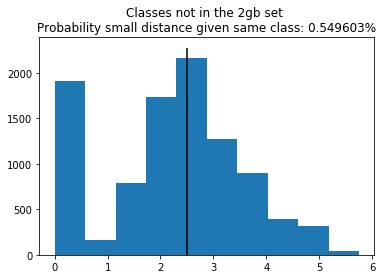

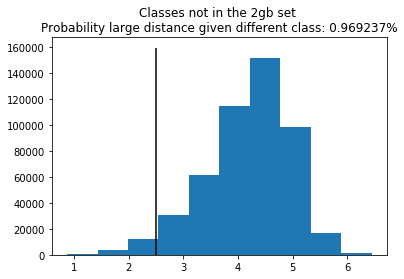

Probability same class given small distance: 0.2606864809283651
Probability different class given large distance: 0.9909118745534571


In [12]:
bitvector_X, bitvector_y = get_embedding(bitvector_model, datagen, [])
evaluate_one_shot_learning(bitvector_X, bitvector_y, 2.5, "Classes not in the 2gb set \n")

Distances in the vector embedding still appear to be imformative on whether two instances belong to the same class, even though now the uncertainties are greater.

Now lets evaluate the performance of the second embedding that tries to include the taxonomic distance of the plankton. First lets consider the performance on the classes included in the 2Gb dataset provided in the assignment:

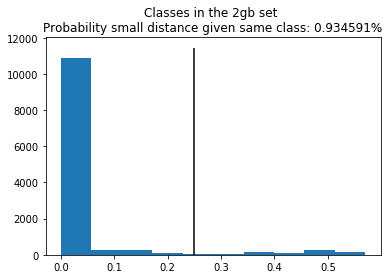

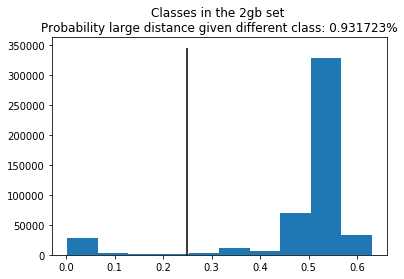

Probability same class given small distance: 0.2572759281543878
Probability different class given large distance: 0.9982266156891835


In [13]:
hierarchy_bitvector_model = load_model(model_path("hierachy_bitvector_"+C.base_model))
hierarchy_bitvector_X, hierarchy_bitvector_y = get_val_embedding(hierarchy_bitvector_model, 2000)
evaluate_one_shot_learning(hierarchy_bitvector_X, hierarchy_bitvector_y, 0.25, "Classes in the 2gb set \n")

The performance of this vector embedding is significantly worse than that of the previously considered vector embedding.

Now, lets evaluate the performance of the one-shot classifier on the ZooScanNet classes not included in the 2Gb dataset provided in the assignment:

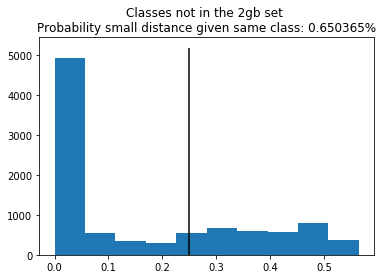

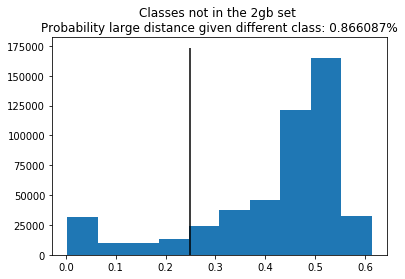

Probability same class given small distance: 0.0876873958911716
Probability different class given large distance: 0.9920739392241983


In [14]:
hierarchy_bitvector_X, hierarchy_bitvector_y = get_embedding(hierarchy_bitvector_model, datagen, [])
evaluate_one_shot_learning(hierarchy_bitvector_X, hierarchy_bitvector_y, 0.25, "Classes not in the 2gb set \n")

Yeah... That is pretty much useless..

# Conclusion:
- A nearest neighbour classifier taking the embedding found by using the standard loss function presented in class performed as well as the "inception/transfer learning" based NN that was used as the base model for the siamese NN model used in this assignment.

- My attempts of including taxonomic distane in the embedding space did not produce very exciting results.

- Using the embedding for one-shot learning of plankton worked quite OK when I used the first vector embedding based on the loss function presented in class.
